In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import vgg19
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda'

In [3]:
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    T.Lambda(lambda x: x.mul_(255))
])
postprocess = T.Compose([
    T.Lambda(lambda x: x.mul_(1./255)),
    T.Normalize(mean=[-0.485/0.229, -0.456/0.224,-0.406/0.225], std=[1/0.229,1/0.224,1/0.255]),
])

In [4]:
class GramMatrix(nn.Module):
    def forward(self,input):
        b,c,h,w = input.size()
        feat = input.view(b,c,h*w)
        G = feat@feat.transpose(1,2)
        G.div_(h*w)
        return G
class GramMSELoss(nn.Module):
    def forward(self,input,target):
        out = F.mse_loss(GramMatrix()(input),target)
        return(out)
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained=True).features)
        self.features = nn.ModuleList(features).eval()
    
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers:
                _results.append(x)
        
        for o in order:
            results.append(_results[o])
        
        return results if layers is not [] else x

In [5]:
vgg = vgg19_modified().to(device)

C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guilh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
!wget https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200.png
!wget https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg

'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.
'wget' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [7]:
imgs = [Image.open(path).resize((512,512)).convert('RGB') for path in ['picasso.png','elephant.png']]
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [8]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [9]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [10]:
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [11]:
style_weights = [1000/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
weights = style_weights + content_weights

In [12]:
style_target = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_target + content_targets

In [13]:
max_iters = 500
optimizer = optim.LBFGS([opt_img])

In [14]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        return loss
    optimizer.step(closure)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0879028..1.8943628].


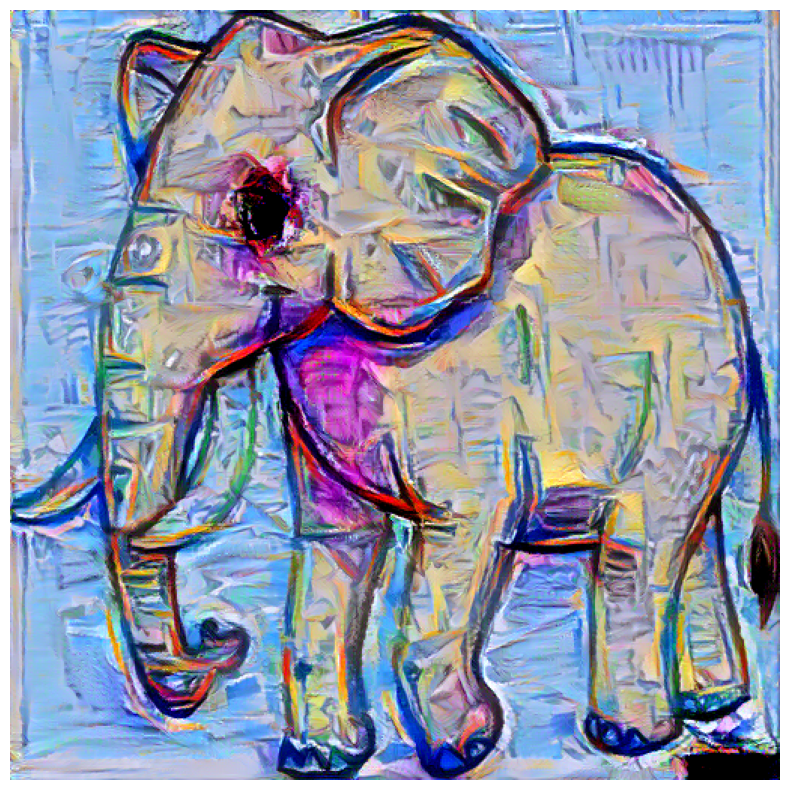

In [15]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)

show(out_img)